# Context

Survival - Выживший:	0 = Нет, 1 = Да
Pclass	- Класс каюты:	1 = 1-ый, 2 = 2-ой, 3 = 3-ий
Sex	- Пол
Age	- Возраст в годах
Sibsp - Сестры или братья / родственники не на борту Титаника
Parch - Родители / дети не на борту Титаника
Ticket	- Номер билета
Fare - Стоимость билета
Cabin	- Номер каюты
Embarked - Порт посадки:	C = Cherbourg, Q = Queenstown, S = Southampton

Целью данного исследования является выявление признаков, влияющих на выживаемость пассажиров.

Предположительно, на выживаемость оказывают влияние такие признаки как:
- пол,
- возраст,
- класс каюты,
- наличие родителей/детей за пределами корабля.

# Data quality assessment

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
titanic = pd.read_csv('train.csv', sep=',')
titanic.head(10)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


При рассмотрении данных, можно определить явные переменные, которые не оказывают никакого влияния на полученные результаты. Таким образом сразу можно исключить переменные 'Name' и 'fare'. Так как 'fare' - стоимость билета влияет только на класс каюты пассажира, однако не оказывает влияния на итоговый результат. Номер билета - 'Ticket', место посадки - 'Embarked' также как и номер каюты - 'Cabin', тоже не влияют на выживаемость пассажира.

Исключив явные фичи, не влияющие на результат, рассмотрим детальнее имеющиеся данные на наличие пропусков.

In [66]:
titanic_data = titanic.drop(columns=['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Sex          100000 non-null  object 
 4   Age          96708 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.3+ MB


# Data exploration

Из полученной информации видно, что значения Age, имеет некоторое количество пропусков, которые следует либо исключить, либо заполнить средним значением. Я предпочту второй вариант. Для этого сначала заполним пропуски 0, а затем определим для каждого из полов количество выживших и погибших.


In [67]:
titanic_data = titanic_data.fillna(0)

male_survived = titanic_data.loc[(titanic_data['Age']==0.00) & (titanic_data['Sex']=='male')].groupby('Survived').agg({'Survived': 'count'})
print(male_survived)
female_survived = titanic_data.loc[(titanic_data['Age']==0.00) & (titanic_data['Sex']=='female')].groupby('Survived').agg({'Survived': 'count'})
print(female_survived)

          Survived
Survived          
0             1517
1              390
          Survived
Survived          
0              419
1              966


Можно заметить, что среди мужчин с пропущенным значением возраста преобладает количество погибших, у женщин же - обратная ситуация. Таким образом, пропущенные значения возраста мужчин можно заполнить средним значением возраста погибших мужчин, а у женщин - средним значением возраста выживших женщин.

In [68]:
mean_fem_age = round(titanic_data.loc[(titanic_data['Survived']==1) & (titanic_data['Sex']=='female') & (titanic_data['Age'] != 0.00)].Age.mean(), 2)
print(mean_fem_age)

mean_man_age = round(titanic_data.loc[(titanic_data['Survived']==0) & (titanic_data['Sex']=='male') & (titanic_data['Age'] != 0.00)].Age.mean(), 2)
print(mean_man_age)

41.27
36.62


Теперь заполним пропущенные значения мужчин и женщин полученными значениями.

In [69]:
titanic_data.loc[(titanic_data['Sex'] == 'male') & (titanic_data['Age'] == 0.00), 'Age'] = 36.62
titanic_data.loc[(titanic_data['Sex'] == 'female') & (titanic_data['Age'] == 0.00), 'Age'] = 41.27

 Для того, чтобы определить, являются ли данные переменные значимыми, построим тепловую карту, отражающую корреляцию переменных.
Так как данный тип графиков применим только для числовых переменных, следует заменить категориальные значения на числовые. Таким образом, в графе Sex, изменим значение male - 0, female - 1.

<AxesSubplot:>

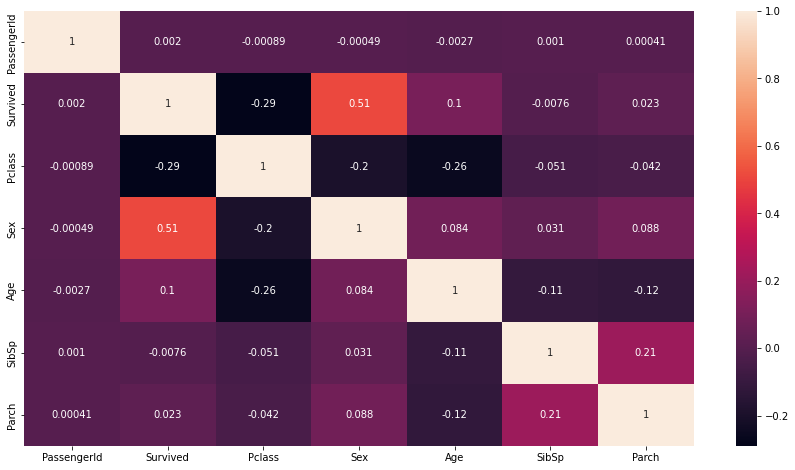

In [114]:
titanic_data['Sex'] = titanic_data['Sex'].replace({'male': 0, 'female': 1})
plt.figure(figsize = (15,8))
sns.heatmap(titanic_data.corr(), annot=True)

Исходя из полученных данных, можно сделать выводы,что наиболее коррелирующими признаками в данном датасете являются Survived и Sex, далее следует Survived и Age.
Отрицательно коррелированны:
- Pclass и Survived.

Поэтому, для того, чтобы детальнее рассмотреть предположение о том, что в первую очередь уровень выживаемости зависел от пола пассажира, построим график.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

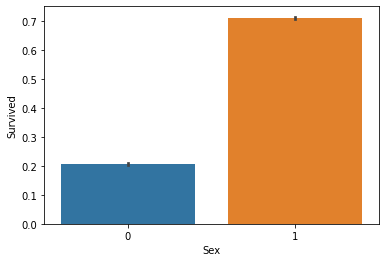

In [71]:
sns.barplot(x='Sex', y='Survived', data=titanic_data)

Таким образом можно сделать вывод, что среди всех пассажиров Титаника, женщин действительно выжило больше, чем мужчин.

Перед тем как рассмотреть зависит ли выживаемость от возраста пассажира, посмотрим на количество пассажиров определенного возраста.

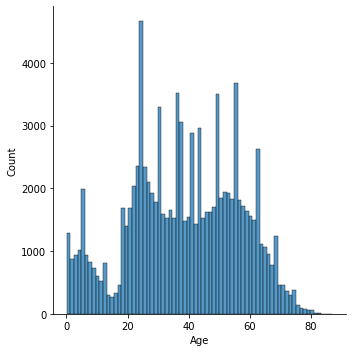

In [72]:
sns.displot(titanic_data['Age'])

Из полученных результатов можно сделать вывод, что либо большинство пассажиров Титаника были в возрасте 23-25 лет, либо данный столбец является выбросом. Однако таких столбцов на полученном графике - 13.

Далее проверим, зависит ли выжил пассажир или нет от его возраста.

<AxesSubplot:xlabel='Survived', ylabel='Age'>

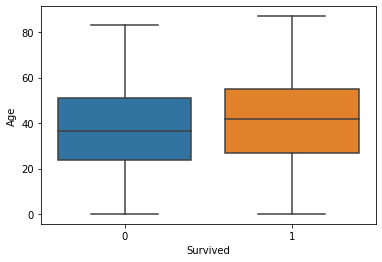

In [117]:
sns.boxplot(x=titanic_data['Survived'], y=titanic_data['Age'])

На графике видно, что преимущественно остались в живых более взрослые пассажиры корабля.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

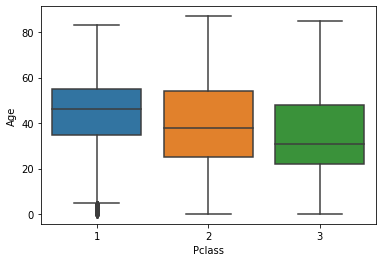

In [74]:
sns.boxplot(x=titanic_data['Pclass'], y=titanic_data['Age'])

Теперь проверим корреляцию между классом каюты и количеством выживших пассажиров.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

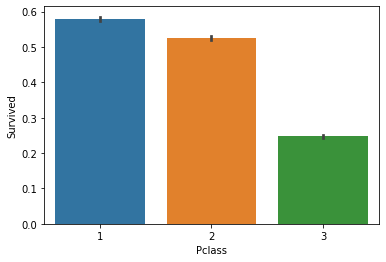

In [75]:
sns.barplot(x=titanic_data['Pclass'], y=titanic_data['Survived'])

Среди выживших оказалось большинство пассажиров 1 и 2 класса, в то время, как большинство пассажиров 3 класса погибли. Для большей достоверности можно подсчитать точное количество выживших в зависимости от класса.

In [76]:
pclass_survived = titanic_data.loc[titanic_data['Survived'] == 1].groupby('Pclass').agg({'Survived': 'count'})
print(pclass_survived)

        Survived
Pclass          
1          17576
2          15057
3          10141


Теперь посмотрим сколько пассажиров имело определенное количество родственников, не находящихся на борту корабля, и повлияло ли это каким-то образом на то, выжил этот пассажир или нет.

   Parch  Passenger
0      0      73540
1      1      12996
2      2      11236
3      3        983
4      4        446
5      5        331
6      6        204
7      9        264


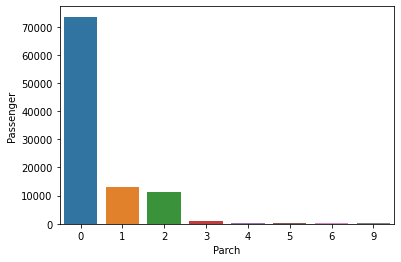

In [104]:
parch = titanic_data.groupby('Parch').agg({'Parch': 'count'}).rename(columns={'Parch': 'Passenger'}).reset_index()
sns.barplot(y='Passenger', x='Parch', data=parch)
print(parch)

Большинство пассажиров не имело ни родителей, ни детей за пределами Титаника.

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

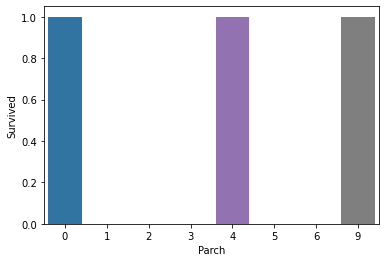

In [113]:
sns.barplot(x=parch['Parch'], y=titanic_data['Survived'])

В основном среди выживших оказались люди не имеющие детей и родственников, либо имеющие 4/9 человек. Также, основываясь на слабой корреляции - 0.023 можно сделать вывод, что наличие родственников/детей вне корабля, не оказывает влияния на то, выжил ли данный пассажир или нет.

# Summary

В результате проведенного разведочного анализа данных были доказаны такие гипотезы, как:
- влияние пола на выживаемость пассажира,
- влияние возраста на выживаемость пассажира,
- влияние класса каюты на выживаемость пассажира,
- влияние возраста на класс каюты пассажира. Более взрослые пассажиры ехали 1 классом.
- влияние наличия родителей / детей за пределами корабля на выживаемость пассажира.

Также были исключены фичи, не оказывающие влияния на результаты анализа (Ticket, Cabin, Embarked, Fare, Name). После рассмотрения данных, было выявлено, что параметр Age имеет некоторое количество пропусков. Для заполнения пропусков было определно выжил или погиб данный пассажир, в зависимости от его пола. В результате анализа мы получили данные, указывающие, что большинство мужчин, у которых возраст не был указан - погибли, а большинство женщин - выжили. Далее был высчитан средний возраст погибших мужчин и средний возраст выживших женщин. Данными значениями были заполнены пропуски в возрасте.

Для изучения корреляции данных была построена тепловая карта, результатами которой является положительная корреляция между фичами:
- Survived - Sex (0.51)
- Survived - Age (0.1)
- Survived - Parch (0.023)

И отрицательная корреляция:
- Survived - Pclass (-0.29)

При детальном рассмотрении влияния пола пассажира на его выживаемость, было выявлено, что среди всех выживших пассажиров, большинство оказалось женщинами. Что доказывает 1 выдвинутую гипотезу.

Далее была построена гистограмма, с целью рассмотреть количество пассажиров в каждой возрастной категории. Полученные данные говорят, что среди пассажиров преобладали молодые люди возрастом 23-25 лет. Чтобы определить, оказывает ли возраст влияние на то, выжил ли данный человек или нет, был построен Boxplot, на котором мы можем увидеть, что среди выживших оказалось большинство пассажиров в возрасте от 25 до 50 лет. Таким образом была доказана 2 гипотеза.

Для определения влияния класса каюты пассажира на его жизнь, так же был построен Boxplot, из которого можно сделать вывод, что большинство выживших пассажиров плыло 1-ым классом, что оказывается вполне логичным, зная причину гибели Титаника.  Была доказана 3 выдвинутая гипотеза.

Так как возраст пассажира и класс каюты влияют на то, выживет он или нет, было логичным определить возраст пассажиров, купивших билет в тот или иной класс. Полученные результаты говорят о том, что среди людей, ехавших первым классов большинство находятся в возрастных границах 38-58 лет.

Так как слабая корреляция была выявлена между фичами Survived и Parch, было решено проверить их зависимость. Для этого сначала мы определили пассажиров, имевших то или иное количество родителей/детей, не находящихся на борту корабля. Большинство пассажиров не имело ни тех, ни других, либо плыли семьями, что также можно теоретически предположить. Далее, рассмотрев влияние наличия родственников вне корабля на выживаемость, увидели, что среди выживших большинство либо не имело родственников, либо имело 4/9 членов семьи вне корабля. Отсюда можно сделать вывод, что наличие родителей или детей не оказало влияния на выживаемость пассажира.

Таким образом, исходя из полученных значений можно сделать вывод, что среди выживших пассажиров большинство было женщинами среднего или пожилого возраста, ехавшими 1 классом.